# Imports

Please note that this page is still being cleaned. I apologize for some of the messiness

In [1]:
import sys
import pprint
import json
import numpy as np
import pandas as pd
from dateutil.parser import parse
from pymongo import MongoClient
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from gensim.summarization.summarizer import summarize
from numpy.linalg import norm
import string
from nltk.tokenize import word_tokenize


#from scipy.sparse.csc_matrix import transpose

#import seaborn as sns
%matplotlib inline


print("python Version:", sys.version)

python Version: 3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
!python --version

Python 3.5.2 :: Anaconda 4.2.0 (64-bit)


# Db Config

In [3]:
client = MongoClient()
db = client.presidents
paragraphs = db.submissions
full_speeches = db.fullspeeches

In [4]:
# speeches.delete_many({})

In [5]:
# with open('/home/karlrudeen/presidentialspeeches9.json', encoding='utf-8') as data_file:    
#     data = json.load(data_file)
#     speeches.insert_many(data)

In [7]:
paragraphs.count()

21968

In [8]:
full_speeches.count()

960

It is worth looking at our speech data on the speech level, and the paragraph within speech model. Speeches tend to cover a wide range of subjects, so when it comes to topic modeling, it may make more sense to model on individual paragraphs within speeches.

In [22]:
s = 'a/,db'
exclude = set(string.punctuation)
s = ''.join(ch for ch in s if ch not in exclude)
s

'adb'

In [23]:
par_list = []

for par in paragraphs.find():
    #pprint.pprint(speech)
    if len(par['text']) > 140:
        exclude = set(string.punctuation)
        par['text'] = ''.join(ch for ch in par['text'].replace('</p>',' ').lower() if ch not in exclude)
        par_list.append(par)
    
#     speech_text.append(speech['text'].replace('<p>', '').\
#                        replace('(Applause.)',' ').replace('(applause)','').replace('inaudible','').split('<br>'))

In [24]:
df_pars = pd.DataFrame(par_list)

In [25]:
fullspeech_list = []

for fullspeech in full_speeches.find():
    if len(fullspeech['text']) > 500:
        fullspeech['text'] = fullspeech['text'].replace('\n',' ').lower()
        fullspeech_list.append(fullspeech)

In [26]:
df_full_speeches = pd.DataFrame(fullspeech_list)

In [27]:
def num_freqs_tup(ser):
    #find 
    arr1 = ser.tolist()
    m = max([arr1.count(a) for a in arr1])
    return (m,len(arr1))

In [28]:
def series_to_list(ser):
    return list(ser.tolist())

# NMF

The idea here is to do a grid search on varying levels of maximum document frequency (max_df) and number of topics (n_comps). The lower max_df is, the fewer words are included in the data.

I want to find a combination of n_comps and max_df that gives each president his own signature topic. I need some way to quantify how well the algorithm has done in this regard, so I created a metric. I call the metric Favorite Topic Frequency (FTF). The formula for FTF is FTF = t/s, where t is the total count of speeches by that president that fall under that presidents most frequent topic, and s is the total number of speeches given by that topic.

In [15]:
def num_freqs_tup(ser):
    arr1 = ser.tolist()
    m = max([arr1.count(a) for a in arr1])
    return (m,len(arr1))

In [16]:
# #code below commented out because it takes forever to load. Pickles are here instead/

# import pickle

# with open('par_data.pkl', 'wb') as picklefile:
#     pickle.dump(speech_stats, picklefile)

# with open('speech_data.pkl', 'wb') as picklefile:
#     pickle.dump(full_speech_stats, picklefile)

In [17]:
with open("par_data.pkl", 'rb') as picklefile: 
    speech_stats = pickle.load(picklefile)

with open("speech_data.pkl", 'rb') as picklefile: 
    full_speech_stats = pickle.load(picklefile)

In [18]:
# max_dfs = [.05, .10, .15, .20, .25, .30]
# n_comps = [5,10,20,30,40]
# speech_stats =[]

# for freq in max_dfs:
#     for n_comp in n_comps:
#         tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
#                         stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq)
#         tfidf_vectorizer.fit(df_pars['text'])

#         counts = tfidf_vectorizer.transform(df_pars['text'])
#         id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
#         model = NMF(n_components=n_comp, init='random', random_state=0)
#         doc_topics = model.fit_transform(counts)

#         doc_cluster = [list(r).index(max(r)) for r in doc_topics]
#         df_pars['NMF_topic_num'] = doc_cluster

#         tups = df_pars.groupby('president').agg({
#             'NMF_topic_num': num_freqs_tup
#             })['NMF_topic_num']
#         metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])
        
#         speech_stats.append((n_comp, freq, metricthing))

Data with paragraphs as documents

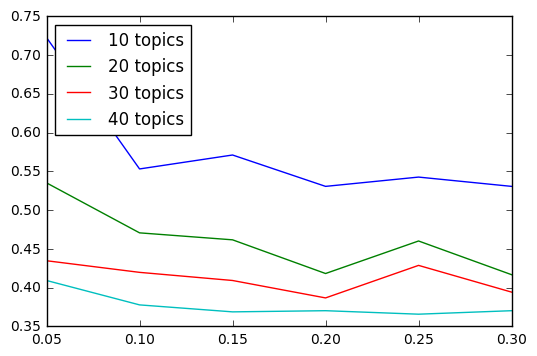

In [18]:
nums_tens = [(num[1],num[2]) for num in speech_stats if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in speech_stats if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in speech_stats if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in speech_stats if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')


One can see from observation that max_df = .05 and 10 topics optimizes FTF. However, I am not going to use this configuration for my final model. There are a couple reasons. First, one can see that FTF increases as the number of topics decreases. I think this is a flaw in my metric, more than an indication that less topics is better. The goal is to give each president a signature topic but what good is a signature topic if five other presidents also have that topic as their signature? 

In [19]:
# fullspeech_list = []

# for fullspeech in full_speeches.find():
#     if len(fullspeech['text']) > 500:
#         fullspeech['text'] = fullspeech['text'].replace('\n',' ')
#         fullspeech_list.append(fullspeech)

In [20]:
# df_full_speeches = pd.DataFrame(fullspeech_list)

In [21]:
# max_dfs = [.05, .10, .15, .20, .25, .30]
# n_comps = [10,20,30,40]
# full_speech_stats = []

# for freq in max_dfs:
#     for n_comp in n_comps:
#         tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
#                         stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq)
#         tfidf_vectorizer.fit(df_full_speeches['text'])

#         counts = tfidf_vectorizer.transform(df_full_speeches['text'])
#         id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
#         model = NMF(n_components=n_comp, init='random', random_state=0)
#         doc_topics = model.fit_transform(counts)

#         doc_cluster = [list(r).index(max(r)) for r in doc_topics]
#         df_full_speeches['NMF_topic_num'] = doc_cluster

#         tups = df_full_speeches.groupby('president').agg({
#             'NMF_topic_num': num_freqs_tup
#             })['NMF_topic_num']
#         metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

#         full_speech_stats.append((n_comp,freq,metricthing))

data with full speeches as documents

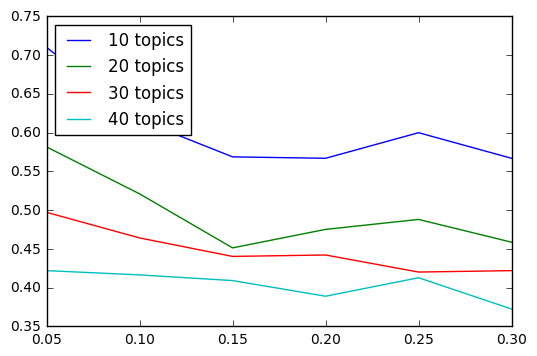

In [22]:
nums_tens = [(num[1],num[2]) for num in full_speech_stats if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')


There are a few takeaways here. First note that FTF goes down as max_df goes up. Second, there isn't that much difference in FTF between full_speeches and paragraphs. All things being equal, it is good to improve granularity, so I think it is best to use paragraphs as my documents. Now, using the graph as a guide, I will look at the topic words of a few different combination of max_df and number of topics.

In [29]:
def mode(arr):
    arr = [num for num in arr if num !=-1]
    m = max([arr.count(a) for a in arr])
    return [x for x in arr if arr.count(x) == m][0] if m>0 else None

In [30]:
def average_tuples(ser):
    mylist = ser.tolist()
    return [np.mean(tup) for tup in list(zip(*mylist))]

In [31]:
def my_count(arr, thing_to_count):
    return arr.count(thing_to_count)/len([num for num in arr if num !=-1])

In [32]:
def create_topics(n_comp, freq_full):
    #vectorize documents
    tfidf_vectorizer_par = TfidfVectorizer(ngram_range=(1, 2),  
                            stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", min_df = 5, max_df = freq_full)
    tfidf_vectorizer_par.fit(df_pars['text'])
    
    
    counts_par = tfidf_vectorizer_par.transform(df_pars['text'])
    
    id2word = dict((v, k) for k, v in tfidf_vectorizer_par.vocabulary_.items())

    # creating and fitting the model
    model = NMF(n_components=n_comp, init='random', random_state=0)
    model.fit(counts_par)
    
    #get data out of the model
    par_topics = model.transform(counts_par)
    doc_cluster = [list(r).index(max(r)) for r in par_topics]

    #put it into the existing dataframe
    df_pars['NMF_topic_num'] = doc_cluster
    
    #calculate FTF score
    tups = df_pars.groupby('president').agg({
             'NMF_topic_num': num_freqs_tup
             })['NMF_topic_num']
    FTF = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])
    
    #get closely associated words for each topic
    topic_words = []
    for r in model.components_:
        a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
        topic_words.append([id2word[e[1]] for e in a])
        
    return {'topic_words': topic_words, 'par_topics': par_topics, 'FTF': FTF}

In [33]:
topic_dict = create_topics(20,.05)

In [34]:
topic_dict['topic_words']

[['executive', 'duty', 'authority', 'powers', 'subject', 'federal', 'duties'],
 ['business', 'foreign', 'labor', 'banks', 'trade', 'policy', 'industry'],
 ['let', 'say', 'let say', 'tonight', 'remember', 'hope', 'ask'],
 ['vietnam',
  'south',
  'south vietnam',
  'north',
  'vietnamese',
  'north vietnam',
  'south vietnamese'],
 ['think', 'going', 'say', 'things', 'like', 'dont', 'tell'],
 ['treaty', 'mexico', 'texas', 'mexican', 'republic', 'territory', 'minister'],
 ['military', 'forces', 'force', 'army', 'armed', 'troops', 'navy'],
 ['americans',
  'children',
  'fellow',
  'fellow americans',
  'women',
  'men women',
  'million'],
 ['union', 'soviet', 'soviet union', 'nuclear', 'europe', 'weapons', 'east'],
 ['service',
  'commission',
  'examination',
  'classified',
  'person',
  'department',
  'place'],
 ['house',
  'representatives',
  'house representatives',
  'senate',
  'white',
  'white house',
  'resolution'],
 ['party',
  'democratic',
  'republican',
  'democratic p

In [35]:
par_cluster = [list(r).index(max(r)) if max(list(r)) > .003 else -1 for r in topic_dict['par_topics']]

In [36]:
par_cluster.count(-1)/len(topic_dict['par_topics'])

6.785641582411617e-05

In [37]:
df_pars['NMF_topic_num'] = par_cluster

In [38]:
df_pars['NMF_topic_amts'] = [tuple(doc) for doc in topic_dict['par_topics']]

In [39]:
# okeything = df_full_speeches.groupby('president').agg({
#     'NMF_topic_num': num_freqs_tup,
#     'NMF_topic_amts' : average_tuples
#     })['NMF_topic_num']

tups = df_pars.groupby('president').agg({
    'NMF_topic_num': num_freqs_tup
    })['NMF_topic_num']
metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

In [40]:
df_pars

,_id,date,president,text,title,NMF_topic_num,NMF_topic_amts
0,58b34cbbcb3bb02c032a702a,"January 21, 2013",Barack Obama,each time we gather to inaugurate a president ...,"Second Inaugural Address (January 21, 2013)",14,"(0.0, 0.0, 0.00391720742518, 0.000293853222537..."
1,58b34cbbcb3bb02c032a702b,"January 21, 2013",Barack Obama,“we hold these truths to be selfevident that a...,"Second Inaugural Address (January 21, 2013)",14,"(0.00808381390163, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,58b34cbbcb3bb02c032a702d,"January 21, 2013",Barack Obama,today we continue a neverending journey to bri...,"Second Inaugural Address (January 21, 2013)",14,"(0.0, 0.0, 0.000927233735429, 0.0, 0.004389628..."
3,58b34cbbcb3bb02c032a7031,"January 21, 2013",Barack Obama,through blood drawn by lash and blood drawn by...,"Second Inaugural Address (January 21, 2013)",8,"(0.011808089728, 0.0, 0.000411043291916, 0.0, ..."
4,58b34cbbcb3bb02c032a7033,"January 21, 2013",Barack Obama,together we determined that a modern economy r...,"Second Inaugural Address (January 21, 2013)",1,"(0.0, 0.0360658573197, 0.0, 0.0, 0.0, 0.000579..."
5,58b34cbbcb3bb02c032a7039,"January 21, 2013",Barack Obama,through it all we have never relinquished our ...,"Second Inaugural Address (January 21, 2013)",0,"(0.0204685271883, 0.0, 0.000302180255186, 0.0,..."
6,58b34cbbcb3bb02c032a703b,"January 21, 2013",Barack Obama,but we have always understood that when times ...,"Second Inaugural Address (January 21, 2013)",12,"(0.00657580811278, 0.0, 0.0, 2.65060771172e-05..."
7,58b34cbbcb3bb02c032a703d,"January 21, 2013",Barack Obama,this generation of americans has been tested b...,"Second Inaugural Address (January 21, 2013)",7,"(0.0, 0.00750478949137, 0.0, 0.0, 0.0, 0.00122..."
8,58b34cbbcb3bb02c032a703f,"January 21, 2013",Barack Obama,for we the people understand that our country ...,"Second Inaugural Address (January 21, 2013)",17,"(0.0, 0.0287424398081, 0.0024281754674, 0.0, 0..."
9,58b34cbbcb3bb02c032a7041,"January 21, 2013",Barack Obama,we understand that outworn programs are inadeq...,"Second Inaugural Address (January 21, 2013)",12,"(0.00523274775821, 0.0, 0.00233184015368, 0.0,..."


In [41]:
final_df = df_pars.groupby('president', as_index = False).agg({
    'NMF_topic_num': series_to_list,
    'NMF_topic_amts' : average_tuples
    })

In [42]:
final_df

,president,NMF_topic_amts,NMF_topic_num
0,Abraham Lincoln,"[0.0161351822852, 0.0183162062689, 0.001780442...","[5, 1, 3, 5, 5, 5, 5, 5, 1, 5, 1, 0, 1, 17, 1,..."
1,Andrew Jackson,"[0.052253261389, 0.0108390701732, 0.0014015951...","[10, 0, 0, 0, 0, 17, 0, 0, 10, 0, 5, 0, 0, 0, ..."
2,Andrew Johnson,"[0.0362207419107, 0.00770841247945, 0.00170085...","[10, 0, 0, 0, 0, 16, 0, 0, 10, 10, 0, 10, 10, ..."
3,Barack Obama,"[0.00220805215915, 0.007447284234, 0.009234722...","[14, 14, 14, 8, 1, 0, 12, 7, 17, 12, 15, 17, 1..."
4,Benjamin Harrison,"[0.0125732801783, 0.0331082851198, 0.001493828...","[5, 1, 1, 4, 5, 11, 0, 16, 11, 11, 1, 11, 1, 1..."
5,Bill Clinton,"[0.00312338999134, 0.00679190522268, 0.0127145...","[6, 6, 2, 14, 16, 8, 6, 8, 7, 7, 7, 13, 6, 8, ..."
6,Calvin Coolidge,"[0.0161096033186, 0.0129383301503, 0.003962652...","[18, 18, 0, 14, 18, 18, 18, 18, 4, 14, 1, 1, 1..."
7,Chester A. Arthur,"[0.0163111848361, 0.0162607764852, 0.000941028...","[5, 5, 8, 8, 1, 1, 5, 1, 5, 5, 1, 1, 1, 1, 1, ..."
8,Dwight D. Eisenhower,"[0.00473561568477, 0.00656710086744, 0.0054953...","[0, 8, 14, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8,..."
9,Franklin D. Roosevelt,"[0.0050456212715, 0.0198824388909, 0.004834523...","[16, 0, 16, 18, 4, 6, 8, 6, 8, 10, 0, 1, 6, 6,..."


In [43]:
metricthing

0.2892040442423831

In [44]:
df_pars['date_obj'] = df_pars['date'].apply(parse)

In [45]:
for i in range(20):
    #final_df['topic_' + str(i)] = final_df['NMF_topic_num'].apply(lambda x: my_count(x,i))
    final_df['topic_amt_' + str(i)] = final_df['NMF_topic_amts'].apply(lambda x: x[i]/sum(x))

In [46]:
final_df.iloc[:,3:]

,topic_amt_0,topic_amt_1,topic_amt_2,topic_amt_3,topic_amt_4,topic_amt_5,topic_amt_6,topic_amt_7,topic_amt_8,topic_amt_9,topic_amt_10,topic_amt_11,topic_amt_12,topic_amt_13,topic_amt_14,topic_amt_15,topic_amt_16,topic_amt_17,topic_amt_18,topic_amt_19
0,0.153222,0.173934,0.016907,0.030793,0.023992,0.086383,0.049681,0.010658,0.044541,0.064655,0.023491,0.011912,0.017592,0.008109,0.026846,0.015179,0.014029,0.019983,0.019324,0.188767
1,0.450838,0.093519,0.012093,0.038540,0.013790,0.025993,0.022426,0.003697,0.035117,0.026625,0.093416,0.010262,0.008158,0.016845,0.022307,0.009071,0.003114,0.017787,0.012479,0.083923
2,0.325358,0.069242,0.015278,0.018750,0.013013,0.039389,0.065092,0.004530,0.032160,0.082447,0.076709,0.023462,0.006907,0.076900,0.026546,0.006919,0.007201,0.012214,0.024905,0.072978
3,0.018808,0.063435,0.078660,0.012607,0.149900,0.005109,0.020164,0.092174,0.025331,0.012396,0.014731,0.031068,0.151096,0.032955,0.056523,0.089045,0.076721,0.037735,0.023778,0.007763
4,0.110688,0.291467,0.013151,0.017658,0.027000,0.049791,0.029465,0.017660,0.014292,0.043921,0.031978,0.118959,0.007834,0.051019,0.020043,0.006614,0.012544,0.021481,0.067870,0.046565
5,0.023822,0.051802,0.096974,0.012810,0.086031,0.004048,0.036229,0.126681,0.030694,0.019266,0.020724,0.019083,0.101235,0.048340,0.057474,0.115297,0.072810,0.050808,0.017773,0.008099
6,0.136392,0.109543,0.033550,0.022823,0.044180,0.027766,0.061465,0.015373,0.022494,0.026955,0.012361,0.022288,0.015768,0.016082,0.167121,0.005198,0.008931,0.024543,0.214856,0.012313
7,0.172761,0.172228,0.009967,0.049061,0.025581,0.257640,0.024884,0.012889,0.043434,0.025530,0.048496,0.010524,0.010404,0.008692,0.032126,0.008007,0.013432,0.010404,0.031266,0.032673
8,0.053626,0.074366,0.062229,0.013734,0.030040,0.021184,0.070420,0.021721,0.225098,0.014886,0.008867,0.066686,0.055519,0.023183,0.151945,0.015732,0.019042,0.025709,0.036317,0.009697
9,0.053786,0.211946,0.051536,0.027104,0.063537,0.016263,0.102553,0.045174,0.050056,0.021231,0.015597,0.034189,0.058419,0.012264,0.086869,0.012978,0.047670,0.044803,0.028281,0.015745


In [47]:
final_df['kmeans'] = KMeans(n_clusters = 6).fit_predict(final_df.iloc[:,3:43].as_matrix())

In [48]:
final_df['kmeans'].value_counts()

3    12
1     9
2     7
0     7
4     4
5     3
Name: kmeans, dtype: int64

In [51]:
final_df[final_df['kmeans'] == 2]['president']

0         Abraham Lincoln
7       Chester A. Arthur
19          James K. Polk
26             John Tyler
29       Millard Fillmore
32    Rutherford B. Hayes
41         Zachary Taylor
Name: president, dtype: object

This is the crux of the whole project. A function that takes in a president, outputs that presidents signature topic, a paragraph of text summarizing his speeches on that topic, and some similar presidents ( based on distance and clustering)

In [55]:
df_pars

,_id,date,president,text,title,NMF_topic_num,NMF_topic_amts,date_obj
0,58b34cbbcb3bb02c032a702a,"January 21, 2013",Barack Obama,each time we gather to inaugurate a president ...,"Second Inaugural Address (January 21, 2013)",14,"(0.0, 0.0, 0.00391720742518, 0.000293853222537...",2013-01-21
1,58b34cbbcb3bb02c032a702b,"January 21, 2013",Barack Obama,“we hold these truths to be selfevident that a...,"Second Inaugural Address (January 21, 2013)",14,"(0.00808381390163, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",2013-01-21
2,58b34cbbcb3bb02c032a702d,"January 21, 2013",Barack Obama,today we continue a neverending journey to bri...,"Second Inaugural Address (January 21, 2013)",14,"(0.0, 0.0, 0.000927233735429, 0.0, 0.004389628...",2013-01-21
3,58b34cbbcb3bb02c032a7031,"January 21, 2013",Barack Obama,through blood drawn by lash and blood drawn by...,"Second Inaugural Address (January 21, 2013)",8,"(0.011808089728, 0.0, 0.000411043291916, 0.0, ...",2013-01-21
4,58b34cbbcb3bb02c032a7033,"January 21, 2013",Barack Obama,together we determined that a modern economy r...,"Second Inaugural Address (January 21, 2013)",1,"(0.0, 0.0360658573197, 0.0, 0.0, 0.0, 0.000579...",2013-01-21
5,58b34cbbcb3bb02c032a7039,"January 21, 2013",Barack Obama,through it all we have never relinquished our ...,"Second Inaugural Address (January 21, 2013)",0,"(0.0204685271883, 0.0, 0.000302180255186, 0.0,...",2013-01-21
6,58b34cbbcb3bb02c032a703b,"January 21, 2013",Barack Obama,but we have always understood that when times ...,"Second Inaugural Address (January 21, 2013)",12,"(0.00657580811278, 0.0, 0.0, 2.65060771172e-05...",2013-01-21
7,58b34cbbcb3bb02c032a703d,"January 21, 2013",Barack Obama,this generation of americans has been tested b...,"Second Inaugural Address (January 21, 2013)",7,"(0.0, 0.00750478949137, 0.0, 0.0, 0.0, 0.00122...",2013-01-21
8,58b34cbbcb3bb02c032a703f,"January 21, 2013",Barack Obama,for we the people understand that our country ...,"Second Inaugural Address (January 21, 2013)",17,"(0.0, 0.0287424398081, 0.0024281754674, 0.0, 0...",2013-01-21
9,58b34cbbcb3bb02c032a7041,"January 21, 2013",Barack Obama,we understand that outworn programs are inadeq...,"Second Inaugural Address (January 21, 2013)",12,"(0.00523274775821, 0.0, 0.00233184015368, 0.0,...",2013-01-21


In [70]:
given_president = "Barack Obama"
most_freq_topic = 12
big_text_thing = '. '.join(list(df_pars[(df_pars['NMF_topic_num'] == most_freq_topic) & (df_pars['president'] == given_president)]['text']))

In [72]:
summarize(big_text_thing, split = True)[0]

'but we have always understood that when times change so must we that fidelity to our founding principles requires new responses to new challenges that preserving our individual freedoms ultimately requires collective action  for the american people can no more meet the demands of today’s world by acting alone than american soldiers could have met the forces of fascism or communism with muskets and militias  no single person can train all the math and science teachers we’ll need to equip our children for the future or build the roads and networks and research labs that will bring new jobs and businesses to our shores  now more than ever we must do these things together as one nation and one people.'

In [69]:
print(big_text_thing)

but we have always understood that when times change so must we that fidelity to our founding principles requires new responses to new challenges that preserving our individual freedoms ultimately requires collective action  for the american people can no more meet the demands of today’s world by acting alone than american soldiers could have met the forces of fascism or communism with muskets and militias  no single person can train all the math and science teachers we’ll need to equip our children for the future or build the roads and networks and research labs that will bring new jobs and businesses to our shores  now more than ever we must do these things together as one nation and one people .we understand that outworn programs are inadequate to the needs of our time  so we must harness new ideas and technology to remake our government revamp our tax code reform our schools and empower our citizens with the skills they need to work harder learn more reach higher  but while the mea

In [73]:
def get_pres_info(given_president):
    pres_row = final_df[final_df['president'] == given_president].iloc[0]
    kmeans_cluster_num = int(pres_row['kmeans'])

    closest_presidents = final_df[(final_df['kmeans'] == kmeans_cluster_num) & (final_df['president'] != given_president)]
    if closest_presidents.shape[0] > 5:
        closest_presidents['distancesfromgiven'] = closest_presidents.apply(lambda row :norm(np.array(list(row)[3:23]) - np.array(list(pres_row)[3:23])), axis = 1)
        closest_presidents = closest_presidents.sort_values(by = 'distancesfromgiven', ascending = True).iloc[1:4,:]

    most_freq_topics = list(pres_row['NMF_topic_num'])
    most_freq_topic = mode(most_freq_topics)
    print(topic_dict['topic_words'][most_freq_topic])
    print(list(closest_presidents['president']))
    print(most_freq_topic)
    print(given_president)
    big_text_thing = '. '.join(list(df_pars[(df_pars['NMF_topic_num'] == most_freq_topic) & (df_pars['president'] == given_president)]['text'])) #& (df_speeches['president'] == 'Barack Obama')]['text']))
    print(summarize(big_text_thing, split = True)[0])

In [76]:
get_pres_info('Ronald Reagan')

/home/karlrudeen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['freedom', 'life', 'man', 'history', 'human', 'rights', 'liberty']
['George H. W. Bush', 'Dwight D. Eisenhower', 'Harry S. Truman']
14
Ronald Reagan
ive been thinking a bit at that window ive been reflecting on what the past eight years have meant and mean and the image that comes to mind like a refrain is a nautical one—a small story about a big ship and a refugee and a sailor it was back in the early 80s at the height of the boat people and the sailor was hard at work on the carrier midway which was patrolling the south china sea the sailor like most american servicemen was young smart and fiercely observant the crew spied on the horizon a leaky little boat and crammed inside were refugees from indochina hoping to get to america the midway sent a small launch to bring them to the ship and safety as the refugees made their way through the choppy seas one spied the sailor on deck and stood up and called out to him he yelled hello american sailor hello freedom man.
